In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns


In [166]:
data = pd.read_csv('downloads//data.csv')
data

,Date,City,PM25,O3,NO2,SO2,CO
0,2023-10-02,Toronto-North,36.00,40.00,11.00,1.00,3.00
1,2023-10-03,Toronto-North,38.00,49.00,19.00,1.00,1.00
2,2023-10-04,Toronto-North,54.00,39.00,13.00,1.00,1.00
3,2023-10-05,Toronto-North,57.00,35.00,8.00,1.00,1.00
4,2023-10-06,Toronto-North,46.00,30.00,7.00,1.00,1.00
...,...,...,...,...,...,...,...
21121,2015-07-18,Toronto- West,,34.00,8.00,1.00,2.00
21122,2015-01-01,Toronto- West,,18.00,8.00,2.00,NaN
21123,2015-01-17,Toronto- West,,19.00,25.00,2.00,3.00
21124,2015-03-11,Toronto- West,,25.00,20.00,2.00,2.00


In [167]:
#looking for null values in every column
data.isnull().sum()

Date       0
City       0
PM25       0
O3         0
NO2        0
SO2     2164
CO       520
dtype: int64

<Axes: >

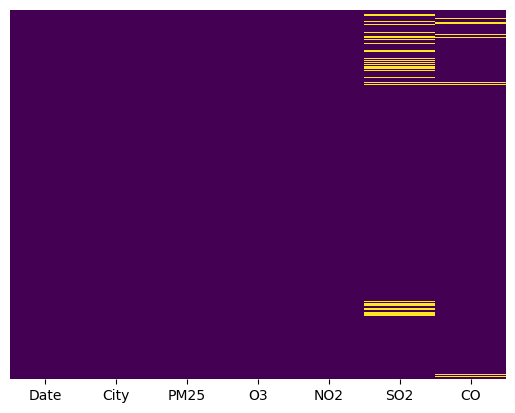

In [168]:
# Shows if there are any null values (yellow part represents null values)
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [169]:

def handle_outliers(data, column_name):

    # Calculate Q1, Q2 and IQR
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Handle outliers
    data[column_name] = data[column_name].apply(lambda x: lower_bound if x < lower_bound else x)
    data[column_name] = data[column_name].apply(lambda x: upper_bound if x > upper_bound else x)
    
    return data


In [170]:
columns_to_check = ["PM25","SO2", "NO2", "CO", "O3"]

for col in columns_to_check:
    data[col] = pd.to_numeric(data[col], errors='coerce')


In [171]:
columns_to_check = ["PM25","SO2", "NO2", "CO", "O3"]

for col in columns_to_check:
    data = handle_outliers(data, col)


In [172]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['city_encoded'] = encoder.fit_transform(data['City'])
data.drop('City', axis=1, inplace=True)


In [173]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)



In [174]:

# Fill missing values - for simplicity, using mean
data.fillna(data.mean(), inplace=True)

# Standardize data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


In [175]:

data.isnull().sum()


PM25            0
O3              0
NO2             0
SO2             0
CO              0
city_encoded    0
dtype: int64

In [176]:
# for col in columns_to_check:
#     data[col].fillna(data[col].median(), inplace=True)


In [177]:
data.isnull().sum()

PM25            0
O3              0
NO2             0
SO2             0
CO              0
city_encoded    0
dtype: int64

,PM25,O3,NO2,SO2,CO,city_encoded
Date,,,,,,
2023-10-02,36.0,40.0,11.0,1.0,3.0,5
2023-10-03,38.0,48.5,19.0,1.0,1.0,5
2023-10-04,54.0,39.0,13.0,1.0,1.0,5
2023-10-05,57.0,35.0,8.0,1.0,1.0,5
2023-10-06,46.0,30.0,7.0,1.0,1.0,5
...,...,...,...,...,...,...
2015-07-18,28.0,34.0,8.0,1.0,2.0,2
2015-01-01,28.0,18.0,8.0,1.0,2.0,2
2015-01-17,28.0,19.0,25.0,1.0,3.0,2


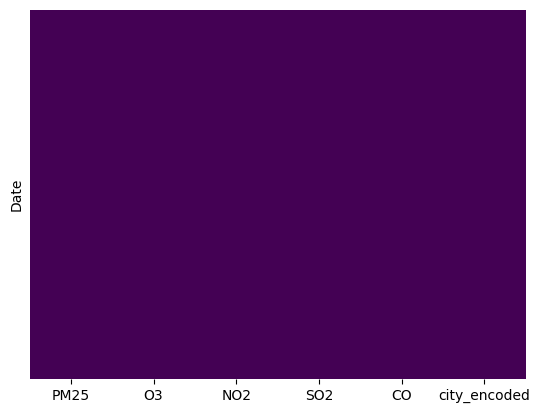

In [101]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')
data


In [102]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(pi):
    if pi <= 30:
        return pi * 50 / 30
    elif pi <= 60:
        return 50 + (pi- 30) * 50 / 30
    elif pi <= 90:
        return 100 + (pi- 60) * 100 / 30
    elif pi <= 120:
        return 200 + (pi- 90) * 100 / 30
    elif pi <= 250:
        return 300 + (pi- 120) * 100 / 130
    elif pi > 250:
        return 400 + (pi- 250) * 100 / 130
    else:
        return pi
data['PMI']=data['PM25'].apply(get_PM25_subindex)
data[['PM25','PMI']].reset_index(drop=True)



,PM25,PMI
0,36.0,60.000000
1,38.0,63.333333
2,54.0,90.000000
3,57.0,95.000000
4,46.0,76.666667
...,...,...
21121,28.0,46.666667
21122,28.0,46.666667
21123,28.0,46.666667
21124,28.0,46.666667


In [74]:
## O3 Sub-Index calculation
def get_O3_subindex(oi):
    if oi <= 50:
        return oi * 50 / 50
    elif oi <= 100:
        return 50 + (oi - 50) * 50 / 50
    elif oi <= 168:
        return 100 + (oi - 100) * 100 / 68
    elif oi <= 208:
        return 200 + (oi - 168) * 100 / 40
    elif oi <= 748:
        return 300 + (oi - 208) * 100 / 539
    elif oi > 748:
        return 400 + (oi - 400) * 100 / 539
    else:
        return oi
data['O3I']=data['O3'].apply(get_O3_subindex)
data[['O3','O3I']].reset_index(drop=True)


,O3,O3I
0,40.0,40.0
1,48.5,48.5
2,39.0,39.0
3,35.0,35.0
4,30.0,30.0
...,...,...
21121,34.0,34.0
21122,18.0,18.0
21123,19.0,19.0
21124,25.0,25.0


In [75]:
## NOx Sub-Index calculation
def get_NOx_subindex(ni):
    if ni <= 40:
        return ni * 50 / 40
    elif ni <= 80:
        return 50 + (ni - 40) * 50 / 40
    elif ni <= 180:
        return 100 + (ni - 80) * 100 / 100
    elif ni <= 280:
        return 200 + (ni - 180) * 100 / 100
    elif ni <= 400:
        return 300 + (ni - 280) * 100 / 120
    elif ni > 400:
        return 400 + (ni - 400) * 100 / 120
    else:
        return ni
data['NOI']=data['NO2'].apply(get_NOx_subindex)
data[['NO2','NOI']].reset_index(drop=True)

,NO2,NOI
0,11.0,13.75
1,19.0,23.75
2,13.0,16.25
3,8.0,10.00
4,7.0,8.75
...,...,...
21121,8.0,10.00
21122,8.0,10.00
21123,25.0,31.25
21124,20.0,25.00


In [76]:
## SO2 Sub-Index calculation
def get_SO2_subindex(si):
    if si <= 40:
        return si * 50 / 40
    elif si <= 80:
        return 50 + (si - 40) * 50 / 40
    elif si <= 380:
        return 100 + (si - 80) * 100 / 300
    elif si <= 800:
        return 200 + (si - 380) * 100 / 420
    elif si <= 1600:
        return 300 + (si - 800) * 100 / 800
    elif si > 1600:
        return 400 + (si - 1600) * 100 / 800
    else:
        return si
data['SOI']=data['SO2'].apply(get_SO2_subindex)
data[['SO2', 'SOI']].reset_index(drop=True)


,SO2,SOI
0,1.0,1.25
1,1.0,1.25
2,1.0,1.25
3,1.0,1.25
4,1.0,1.25
...,...,...
21121,1.0,1.25
21122,1.0,1.25
21123,1.0,1.25
21124,1.0,1.25


In [77]:
## CO Sub-Index calculation
def get_CO_subindex(ci):
    if ci <= 1:
        return ci * 50 / 1
    elif ci <= 2:
        return 50 + (ci - 1) * 50 / 1
    elif ci <= 10:
        return 100 + (ci - 2) * 100 / 8
    elif ci <= 17:
        return 200 + (ci - 10) * 100 / 7
    elif ci <= 34:
        return 300 + (ci - 17) * 100 / 17
    elif ci > 34:
        return 400 + (ci - 34) * 100 / 17
    else:
        return 0
data['COI']=data['CO'].apply(get_CO_subindex)
data[['CO','COI']].reset_index(drop=True)



,CO,COI
0,3.0,112.5
1,1.0,50.0
2,1.0,50.0
3,1.0,50.0
4,1.0,50.0
...,...,...
21121,2.0,100.0
21122,2.0,100.0
21123,3.0,112.5
21124,2.0,100.0


In [78]:
print(data.columns)

Index(['PM25', 'O3', 'NO2', 'SO2', 'CO', 'city_encoded', 'PMI', 'O3I', 'NOI',
       'SOI', 'COI'],
      dtype='object')


In [79]:
def cal_aqi(pi,oi,ni,si,ci):
    aqi=0
    if(pi>oi and pi>ni and pi>si and pi>ci):
        aqi=pi
    if(oi>pi and oi>ni and oi>si and oi>ci):
        aqi=oi
    if(ni>pi and ni>oi and ni>si and ni>ci):
        aqi=ni
    if(si>pi and si>oi and si>ni and si>ci):
        aqi=si
    if(ci>pi and ci>oi and ci>ni and ci>si):
        aqi=ci
    return aqi

data['AQI'] = data.apply(lambda x:cal_aqi(x['PMI'],x['O3I'],x['NOI'],x['SOI'],x['COI']),axis=1)
data[['PMI','O3I','NOI','SOI','COI','AQI']]

,PMI,O3I,NOI,SOI,COI,AQI
Date,,,,,,
2023-10-02,60.000000,40.0,13.75,1.25,112.5,112.500000
2023-10-03,63.333333,48.5,23.75,1.25,50.0,63.333333
2023-10-04,90.000000,39.0,16.25,1.25,50.0,90.000000
2023-10-05,95.000000,35.0,10.00,1.25,50.0,95.000000
2023-10-06,76.666667,30.0,8.75,1.25,50.0,76.666667
...,...,...,...,...,...,...
2015-07-18,46.666667,34.0,10.00,1.25,100.0,100.000000
2015-01-01,46.666667,18.0,10.00,1.25,100.0,100.000000
2015-01-17,46.666667,19.0,31.25,1.25,112.5,112.500000


In [80]:
def get_AQI_Range(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

data['AQI_Range'] = data['AQI'].apply(get_AQI_Range)
data

,PM25,O3,NO2,SO2,CO,city_encoded,PMI,O3I,NOI,SOI,COI,AQI,AQI_Range
Date,,,,,,,,,,,,,
2023-10-02,36.0,40.0,11.0,1.0,3.0,5,60.000000,40.0,13.75,1.25,112.5,112.500000,Moderate
2023-10-03,38.0,48.5,19.0,1.0,1.0,5,63.333333,48.5,23.75,1.25,50.0,63.333333,Satisfactory
2023-10-04,54.0,39.0,13.0,1.0,1.0,5,90.000000,39.0,16.25,1.25,50.0,90.000000,Satisfactory
2023-10-05,57.0,35.0,8.0,1.0,1.0,5,95.000000,35.0,10.00,1.25,50.0,95.000000,Satisfactory
2023-10-06,46.0,30.0,7.0,1.0,1.0,5,76.666667,30.0,8.75,1.25,50.0,76.666667,Satisfactory
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-18,28.0,34.0,8.0,1.0,2.0,2,46.666667,34.0,10.00,1.25,100.0,100.000000,Satisfactory
2015-01-01,28.0,18.0,8.0,1.0,2.0,2,46.666667,18.0,10.00,1.25,100.0,100.000000,Satisfactory
2015-01-17,28.0,19.0,25.0,1.0,3.0,2,46.666667,19.0,31.25,1.25,112.5,112.500000,Moderate


In [81]:
# Define predictors (X) and the target (y)
X = data.drop('PM25', axis=1)
y = data['PM25']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)


In [ ]:
# Make predictions on the test set
predictions = rf.predict(X_test)

# Calculate and print evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f'R-squared: {r2:.2f}')


In [ ]:
# Extract feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. {X_train.columns[indices[f]]} ({importances[indices[f]]})")


In [ ]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
# Histogram of pollutants
data['PM25'].hist()
plt.show()

# Correlation matrix
correlation_matrix = data.corr()
print(correlation_matrix)


In [ ]:
# Drop the 'City' column
data = data.drop('city_encoded', axis=1)

# Drop or impute missing values
data.dropna(inplace=True)

In [ ]:
data.hist(bins=50,figsize=(20,15))
plt.show

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
# Initialize the grid search
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(f"Best parameters found: {grid_search.best_params_}")